### Import useful libraries

In [1]:
%run "Imports.ipynb"
# %run "Helpers.ipynb"

### Load data

In [2]:
# To have same dataset for naive and Prophet predictions, I considered removing rows where naive prediction is missing
# but opted against it for now
# df_all = pd.read_pickle("df_all.pkl")
# df_all_dropna = df_all.dropna()
# data = pd.read_pickle("df_all_dropna.pkl")
data = pd.read_pickle("data.pkl")

In [3]:
data = data[['zone','timestamp', 'supply', 'forecast', 'date', 'hour']]

In [4]:
print(len(data))

951758


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951758 entries, 0 to 951757
Data columns (total 6 columns):
zone         951758 non-null object
timestamp    951758 non-null datetime64[ns]
supply       951758 non-null int64
forecast     934958 non-null float64
date         951758 non-null object
hour         951758 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 43.6+ MB


In [6]:
data.head()

,zone,timestamp,supply,forecast,date,hour
0,0_0_10_10,2019-01-04 14:00:00,1,NaN,2019-01-04,14:00:00
1,0_0_10_10,2019-01-04 15:00:00,0,NaN,2019-01-04,15:00:00
2,0_0_10_10,2019-01-04 16:00:00,0,NaN,2019-01-04,16:00:00
3,0_0_10_10,2019-01-04 17:00:00,0,NaN,2019-01-04,17:00:00
4,0_0_10_10,2019-01-04 18:00:00,0,NaN,2019-01-04,18:00:00


In [7]:
data.fillna(0, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951758 entries, 0 to 951757
Data columns (total 6 columns):
zone         951758 non-null object
timestamp    951758 non-null datetime64[ns]
supply       951758 non-null int64
forecast     951758 non-null float64
date         951758 non-null object
hour         951758 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 43.6+ MB


In [9]:
# data = add_prophet_forecast(data,'2019-12-31 00:00:00')

In [10]:
# data.to_pickle("data_with_prophet.pkl")

In [11]:
data = pd.read_pickle("data_with_prophet.pkl")

In [12]:
data.head()

,zone,timestamp,supply,forecast,date,hour,prophet_forecast
0,0_0_10_10,2019-01-04 14:00:00,1,0.0,2019-01-04,14:00:00,NaN
1,0_0_10_10,2019-01-04 15:00:00,0,0.0,2019-01-04,15:00:00,NaN
2,0_0_10_10,2019-01-04 16:00:00,0,0.0,2019-01-04,16:00:00,NaN
3,0_0_10_10,2019-01-04 17:00:00,0,0.0,2019-01-04,17:00:00,NaN
4,0_0_10_10,2019-01-04 18:00:00,0,0.0,2019-01-04,18:00:00,NaN


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951758 entries, 0 to 951757
Data columns (total 7 columns):
zone                951758 non-null object
timestamp           951758 non-null datetime64[ns]
supply              951758 non-null int64
forecast            951758 non-null float64
date                951758 non-null object
hour                951758 non-null object
prophet_forecast    84602 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 50.8+ MB


In [51]:
mean_supply_dict = calculate_zones_mean_supply(train)

In [52]:
data['zone_mean_supply'] = data['zone'].map(mean_supply_dict)

In [63]:
max_supply_dict = calculate_zones_max_supply(train)

In [54]:
data['zone_max_supply'] = data['zone'].map(max_supply_dict)

In [64]:
mean_improvement_dict = calculate_zones_mean_improvement(test)

In [56]:
data['zones_mean_improvement'] = data['zone'].map(mean_improvement_dict)

In [57]:
data.sample()

,zone,timestamp,supply,forecast,date,hour,prophet_forecast,zone_mean_supply,zone_max_supply,zones_mean_improvement
859113,9_0_10_10,2019-05-03 21:00:00,0,0.0,2019-05-03,21:00:00,NaN,0.086767,4,0.099537


### Helpers

In [14]:
def calculate_prophet_forecast(train, test):
    prophet = Prophet(growth="linear",holidays_prior_scale=10,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
    prophet.add_country_holidays(country_name='PL'
                                ).add_seasonality(name='monthly', period=30.5, fourier_order=55
                                                 ).add_seasonality(name='weekly', period=7, fourier_order=10
                                                                  ).add_seasonality(name='daily', period=1, fourier_order=15) 
    prophet.fit(train)
    future = prophet.make_future_dataframe(periods=len(test), freq='H', include_history=False)
    forecast = prophet.predict(future)
    prophet.plot_components(forecast)
    return forecast

In [15]:
def divide_into_train_and_test(df,cut_date,timestamp):
    train = df[ df[timestamp] < cut_date ]
    test = df[ df[timestamp] >= cut_date ]    
    return train, test

In [16]:
def rename_columns_for_prophet(df):
    df = df[['timestamp','supply']]
    df.columns = ['ds','y']
    df = df.sort_values(by=['ds'])
    return df

In [17]:
def add_prophet_forecast(df,cut_date):
    grouped_by_zone = df.groupby('zone')
    
    for name, group in grouped_by_zone:  
        group = rename_columns_for_prophet(group)
        train, test = divide_into_train_and_test(group,cut_date,'ds')
        print(name)
        
        prophet_forecast = calculate_prophet_forecast(train, test)
            
        i = 0
        for r_idx, row in test.iterrows():
            df.loc[r_idx, 'prophet_forecast'] = prophet_forecast.loc[i,'yhat']
            i = i + 1
                
    return df       

In [18]:
def add_mixed_forecast(df,mean_supply_dict,cut_date):
    grouped_by_zone = df.groupby('zone')
    
    for name, group in grouped_by_zone:  
        train, test = divide_into_train_and_test(group,cut_date,'timestamp')
        print(name)

        if mean_supply_dict[name] > 0.26:            
            i = 0
            for r_idx, row in test.iterrows():
                df.loc[r_idx, 'final_forecast'] =  df.loc[r_idx, 'prophet_forecast']
                i = i + 1
        else:
            for r_idx, row in test.iterrows():
                df.loc[r_idx, 'final_forecast'] = df.loc[r_idx, 'forecast']
    return df   

In [19]:
def add_mixed_forecast2(df,max_supply_dict,cut_date):
    grouped_by_zone = df.groupby('zone')
    
    for name, group in grouped_by_zone:  
        train, test = divide_into_train_and_test(group,cut_date,'timestamp')
        print(name)

        if max_supply_dict[name] > 9:            
            i = 0
            for r_idx, row in test.iterrows():
                df.loc[r_idx, 'final_forecast'] =  df.loc[r_idx, 'prophet_forecast']
                i = i + 1
        else:
            for r_idx, row in test.iterrows():
                df.loc[r_idx, 'final_forecast'] = df.loc[r_idx, 'forecast']
    return df   

In [20]:
def get_zone(df, zone_name):
    grouped_by_zone = df.groupby('zone')
    return grouped_by_zone.get_group(zone_name)

In [21]:
def naive_success_metric(test):
    results = []

    for name, group in test.groupby('timestamp'):
        mean_supply = group['supply'].mean(axis = 0)
        sum_of_errors = group['diff_naive_forecast'].sum()
        
        single_success_metric = sum_of_errors / (mean_supply * len(group))
        results.append(single_success_metric)
        
    return np.percentile(results, 97)

In [22]:
def prophet_success_metric(test):
    results = []

    for name, group in test.groupby('timestamp'):
        mean_supply = group['supply'].mean(axis = 0)
        sum_of_errors = group['diff_prophet_forecast'].sum()
        
        single_success_metric = sum_of_errors / (mean_supply * len(group))
        results.append(single_success_metric)
        
    return np.percentile(results, 97)

In [23]:
def mixed_success_metric(test):
    results = []

    for name, group in test.groupby('timestamp'):
        mean_supply = group['supply'].mean(axis = 0)
        sum_of_errors = group['diff_mixed_forecast'].sum()
        
        single_success_metric = sum_of_errors / (mean_supply * len(group))
        results.append(single_success_metric)
        
    return np.percentile(results, 97)

In [24]:
def calculate_zones_mean_supply(train):
    zone_names = train['zone'].unique()
    MeanSupplyDict = {elem : pd.DataFrame for elem in zone_names}

    for key in MeanSupplyDict.keys():
        MeanSupplyDict[key] = train['supply'][train.zone == key].mean()
        
    return MeanSupplyDict

In [25]:
def calculate_zones_max_supply(train):
    zone_names = train['zone'].unique()
    MaxSupplyDict = {elem : pd.DataFrame for elem in zone_names}

    for key in MaxSupplyDict.keys():
        MaxSupplyDict[key] = train['supply'][train.zone == key].max()
        
    return MaxSupplyDict

In [26]:
def calculate_zones_mean_improvement(train):
    zone_names = train['zone'].unique()
    resultDict = {elem : pd.DataFrame for elem in zone_names}

    for key in resultDict.keys():
        resultDict[key] = train['prophet_improvement'][train.zone == key].mean()
        
    return resultDict

In [58]:
def prepare_xyz(ResultDict):
    zone_results = pd.DataFrame.from_dict(ResultDict, orient='index')
    zone_results = zone_results.reset_index()
    first_column = zone_results.iloc[:, 0] 
    zone_results['x_coordinate'] = zone_results.apply (lambda row: row['index'][:1], axis=1)
    zone_results['y_coordinate'] = zone_results.apply (lambda row: row['index'][2:3], axis=1)
    return [zone_results['x_coordinate'],zone_results['y_coordinate'],zone_results[0]]

In [59]:
def plot_heatmap(x,y,z,cmap='coolwarm'):
    df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
    df.columns = ['X_coordinate','Y_coordinate','max_supply']
    df['max_supply'] = pd.to_numeric(df['max_supply'])

    pivotted= df.pivot('X_coordinate','Y_coordinate','max_supply')
    pivotted
    plt.figure(figsize=(12, 9))
    sns.heatmap(pivotted,annot=True,cmap=cmap)

### Divide into train and test

In [27]:
train, test = divide_into_train_and_test(data,'2019-12-31 00:00:00','timestamp')

In [28]:
test['supply'] = test['supply'].astype(float)

In [29]:
test['diff_naive_forecast'] = abs(test['supply'] - test['forecast'])

In [30]:
test['diff_prophet_forecast'] = abs(test['supply'] - test['prophet_forecast']).round(0)

In [31]:
test['prophet_improvement'] = test['diff_naive_forecast'] - test['diff_prophet_forecast']

### Check Prophet forecast for a single zone

In [32]:
zone = get_zone(data, '5_4_10_10')

In [33]:
zone.tail()

,zone,timestamp,supply,forecast,date,hour,prophet_forecast
521085,5_4_10_10,2020-02-04 19:00:00,25,40.0,2020-02-04,19:00:00,35.500808
521086,5_4_10_10,2020-02-04 20:00:00,31,41.0,2020-02-04,20:00:00,31.848085
521087,5_4_10_10,2020-02-04 21:00:00,32,18.0,2020-02-04,21:00:00,29.679136
521088,5_4_10_10,2020-02-04 22:00:00,21,13.0,2020-02-04,22:00:00,25.491818
521089,5_4_10_10,2020-02-04 23:00:00,29,34.0,2020-02-04,23:00:00,25.703852


5_4_10_10


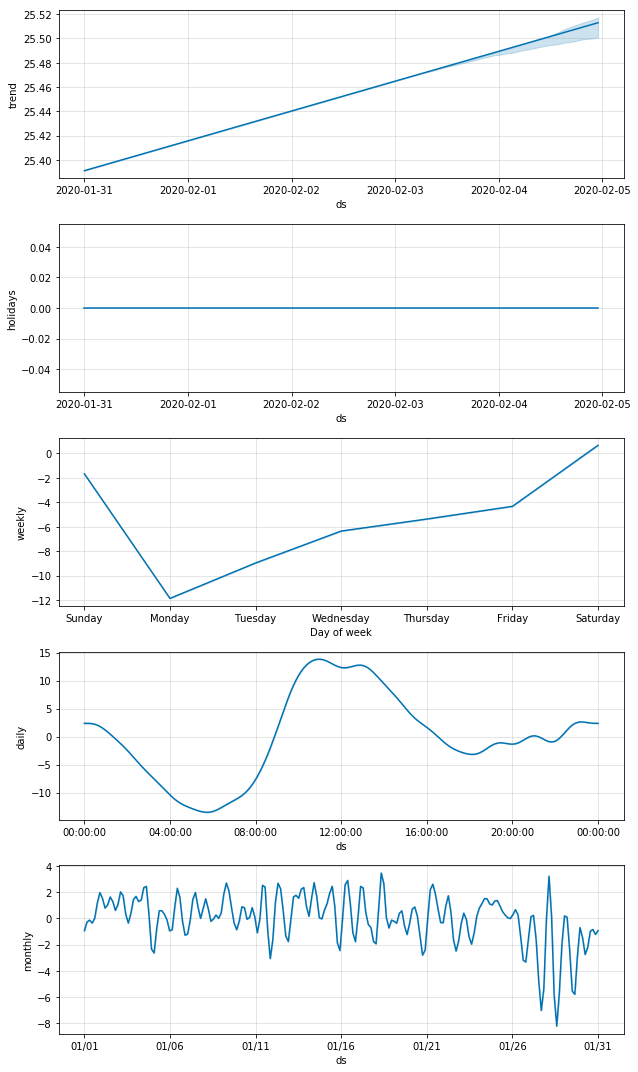

In [34]:
asia = add_prophet_forecast(zone,'2020-01-31 00:00:00')

### Calculate success metrics

In [35]:
naive_success_metric = naive_success_metric(test)

In [36]:
naive_success_metric

1.5018965517241383

In [37]:
prophet_success_metric = prophet_success_metric(test)

In [38]:
prophet_success_metric

2.3297154471544714

### Make some decisions :)

In [60]:
mean_xyz = prepare_xyz(mean_supply_dict)

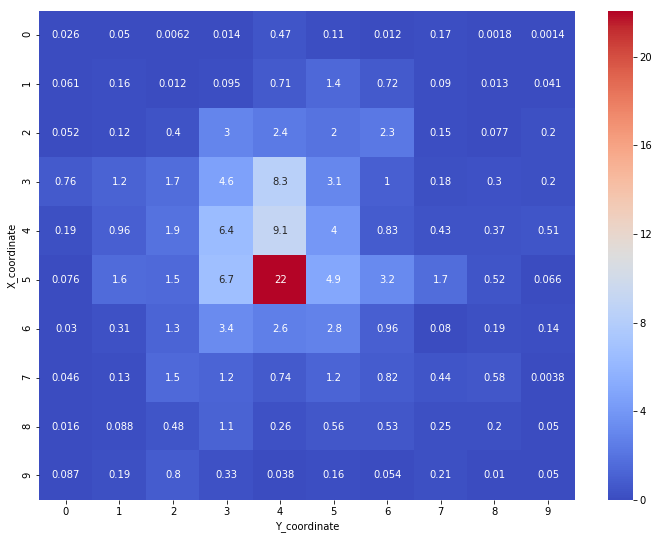

In [61]:
plot_heatmap(*mean_xyz)

In [65]:
max_xyz = prepare_xyz(max_supply_dict)

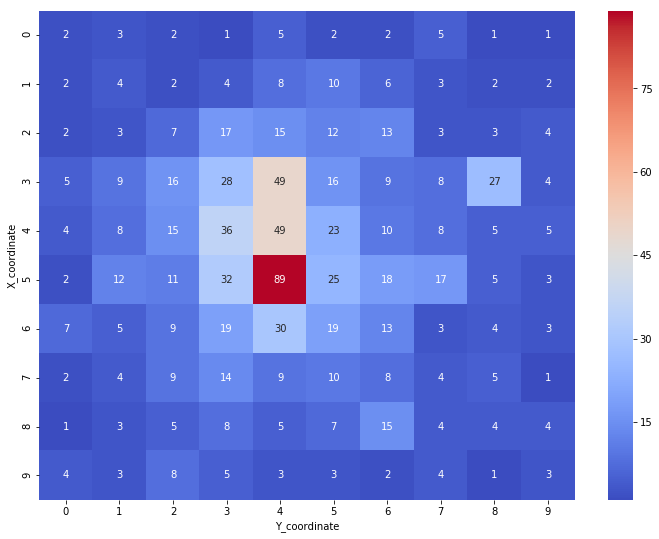

In [66]:
plot_heatmap(*max_xyz)

In [67]:
mean_improvement_xyz = prepare_xyz(mean_improvement_dict)

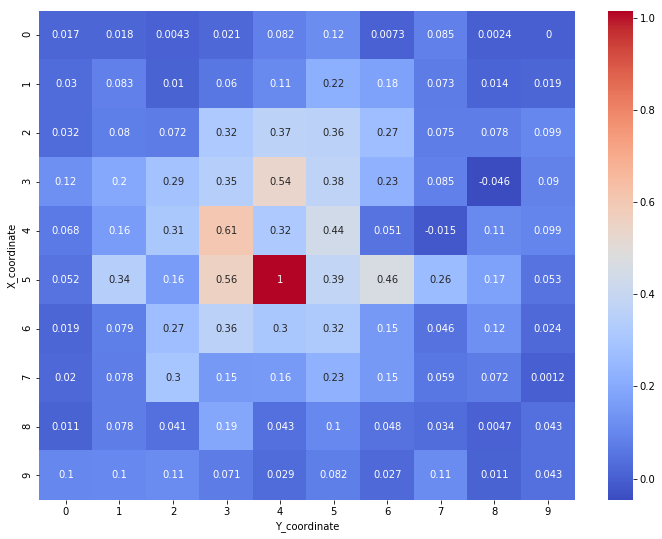

In [68]:
plot_heatmap(*mean_improvement_xyz)